# Mask Detection Model
This is a deep learning model based on the pre-trained FasterRCNN model found in PyTorch. I do have to note that I did not go through with training the model specifically on whether or not it is able to differentiate between incorrectly and correctly worn masks.

The data utilized is off of Kaggle's Face-Mask-Detection dataset, which can be found [here.](https://www.kaggle.com/andrewmvd/face-mask-detection)



#Importing

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d andrewmvd/face-mask-detection

 97% 387M/398M [00:01<00:00, 207MB/s]
100% 398M/398M [00:02<00:00, 201MB/s]


In [3]:
!unzip face-mask-detection.zip

Archive:  face-mask-detection.zip
  inflating: annotations/maksssksksss0.xml  
  inflating: annotations/maksssksksss1.xml  
  inflating: annotations/maksssksksss10.xml  
  inflating: annotations/maksssksksss100.xml  
  inflating: annotations/maksssksksss101.xml  
  inflating: annotations/maksssksksss102.xml  
  inflating: annotations/maksssksksss103.xml  
  inflating: annotations/maksssksksss104.xml  
  inflating: annotations/maksssksksss105.xml  
  inflating: annotations/maksssksksss106.xml  
  inflating: annotations/maksssksksss107.xml  
  inflating: annotations/maksssksksss108.xml  
  inflating: annotations/maksssksksss109.xml  
  inflating: annotations/maksssksksss11.xml  
  inflating: annotations/maksssksksss110.xml  
  inflating: annotations/maksssksksss111.xml  
  inflating: annotations/maksssksksss112.xml  
  inflating: annotations/maksssksksss113.xml  
  inflating: annotations/maksssksksss114.xml  
  inflating: annotations/maksssksksss115.xml  
  inflating: annotations/maksssk

In [4]:
#imports
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches
import os

#Data Pipeline
Here, I create the data pipeline to import the images into the dataset. Most of what I've done here was learned from [PyTorch's TorchVision tutorial.](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)

In [5]:
#Here, we create the functions to gather the locations and labels for the data.

#This one is to collect the corners of the box.
def generate_box(obj):
  xmin = int(obj.find('xmin').text)
  xmax = int(obj.find('xmax').text)
  ymin = int(obj.find('ymin').text)
  ymax = int(obj.find('ymax').text)

  return [xmin, ymin, xmax, ymax]

#This one is to turn labels into classifications
def generate_label(obj): 
  if obj.find('name').text == 'with_mask':
    return 1
  elif obj.find('name').text == 'mask_worn_incorrectly':
    return 2
  else:
    return 0

#This here is to gather the information from the model and provide a target.
def generate_target(image_id, file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        img_id = torch.tensor([image_id])

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target

In [6]:
#Sorting the images so that they're in the correct order 
#(so the labels and images match)
imgs = list(sorted(os.listdir("/content/images/")))
labels = list(sorted(os.listdir("/content/annotations/")))

In [41]:
#Creating a dataset class
class MaskDataset(object):
    #keep in mind the locations indicated here are for google colab
    def __init__(self, transforms):
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir("/content/images/")))
        self.labels = list(sorted(os.listdir("/content/annotations/")))

    def __getitem__(self, idx):
        #pull out the png and the annotations xml from the file locations
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join("/content/images/", file_image)
        label_path = os.path.join("/content/annotations/", file_label)
        img = Image.open(img_path).convert("RGB") #make sure the image is in RGB
        #generate a path
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [42]:
#normalize the RGB values and transform into a tensor:
data_transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize([.485,.456,.406],[0.229,0.224,0.225]),
                                     ])


In [43]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform)
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=32, collate_fn=collate_fn)

#Model

In [44]:
#Pulling the pre-trained FasterRCNN model to train on.
def get_model_instance_segmentation(num_classes):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  return model

In [49]:
model = get_model_instance_segmentation(3) #3 as we have three classes

In [51]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') #eğer gpu yoksa cpu kullan

#Check if the data loading process works
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

[{'boxes': tensor([[ 79., 105., 109., 142.],
        [185., 100., 226., 144.],
        [325.,  90., 360., 141.]], device='cuda:0'), 'labels': tensor([0, 1, 0], device='cuda:0'), 'image_id': tensor([0], device='cuda:0')}, {'boxes': tensor([[321.,  34., 354.,  69.],
        [224.,  38., 261.,  73.],
        [299.,  58., 315.,  81.],
        [143.,  74., 174., 115.],
        [ 74.,  69.,  95.,  99.],
        [191.,  67., 221.,  93.],
        [ 21.,  73.,  44.,  93.],
        [369.,  70., 398.,  99.],
        [ 83.,  56., 111.,  89.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0], device='cuda:0'), 'image_id': tensor([1], device='cuda:0')}, {'boxes': tensor([[ 68.,  42., 105.,  69.],
        [154.,  47., 178.,  74.],
        [238.,  34., 262.,  69.],
        [333.,  31., 366.,  65.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 0], device='cuda:0'), 'image_id': tensor([2], device='cuda:0')}, {'boxes': tensor([[ 52.,  53.,  73.,  76.],
        [ 72.,  53.,  92.,  75.],
  

#Training

In [ ]:
print(len(data_loader))

214


In [52]:
num_epochs = 25
model.to(device)

#parameters: using SGD. Tried various lr, momentum, and wd rates
prms = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(prms, lr = .005, momentum = .9, weight_decay = .0005)

len_dataloader = len(data_loader)

#Unlike Keras, in PyTorch, we need loop per epoch as it won't be done automatically
for epoch in range(num_epochs):
  model.train()
  i = 0
  epoch_loss = 0
  for imgs, annotations in data_loader:
    i += 1
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    loss_dict = model([imgs[0]], [annotations[0]])
    losses = sum(loss for loss in loss_dict.values())

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
    #just to see where we are
    print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}') #- turns out that this was too much effort to look at as it's hard to get which epoch we're on
    epoch_loss += losses
  print(epoch_loss)

Iteration: 1/27, Loss: 1.6422741413116455
Iteration: 2/27, Loss: 0.4330887794494629
Iteration: 3/27, Loss: 122.97074890136719
Iteration: 4/27, Loss: 0.8295544385910034
Iteration: 5/27, Loss: 56498.8046875
Iteration: 6/27, Loss: nan
Iteration: 7/27, Loss: nan
Iteration: 8/27, Loss: nan
Iteration: 9/27, Loss: nan
Iteration: 10/27, Loss: nan
Iteration: 11/27, Loss: nan
Iteration: 12/27, Loss: nan
Iteration: 13/27, Loss: nan
Iteration: 14/27, Loss: nan
Iteration: 15/27, Loss: nan
Iteration: 16/27, Loss: nan
Iteration: 17/27, Loss: nan
Iteration: 18/27, Loss: nan
Iteration: 19/27, Loss: nan
Iteration: 20/27, Loss: nan
Iteration: 21/27, Loss: nan
Iteration: 22/27, Loss: nan
Iteration: 23/27, Loss: nan
Iteration: 24/27, Loss: nan
Iteration: 25/27, Loss: nan
Iteration: 26/27, Loss: nan
Iteration: 27/27, Loss: nan
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
Iteration: 1/27, Loss: nan
Iteration: 2/27, Loss: nan
Iteration: 3/27, Loss: nan
Iteration: 4/27, Loss: nan
Iteration: 5/27, Loss:

KeyboardInterrupt: ignored

In [53]:
#load images from a single batch to evaluate the model on
for imgs, annotations in data_loader:
  imgs = list(img.to(device) for img in imgs)
  annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
  break

In [54]:
#turn model into evaluataion mode to gather results
model.eval()
#get predictions - usually fails on gpu, so push to cpu and reduce batch size
preds = model(imgs)
preds

RuntimeError: ignored

Plots

In [ ]:
#image plotting 
def plot_image(img_tensor, annotation):
    
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data
    print(img.shape)

    # resmi gösteriyor
    ax.imshow(img.permute(1, 2, 0)) #move channel to the end so that the image can be shown accordingly
    
    print(img.shape)
    for box in annotation["boxes"]: #loop over each box
        xmin, ymin, xmax, ymax = box

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

Tahminler
torch.Size([3, 290, 400])


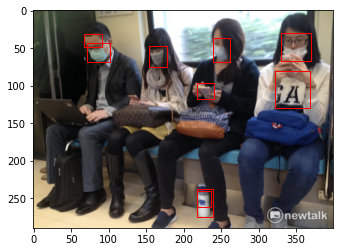

Gerçek
torch.Size([3, 290, 400])


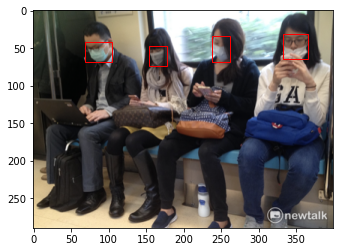

In [ ]:
print("Predictions")
plot_image(imgs[2], preds[2])
print("Truth")
plot_image(imgs[2], annotations[2])

#Re-Loading
In PyTorch, reloading the model's weights is easier than reloading the whole model.

State Dict here is referring to model weights.

In [ ]:
torch.save(model.state_dict(), 'model.pt')

In [ ]:
model2 = get_model_instance_segmentation(3)

In [ ]:
model2.load_state_dict(torch.load('model.pt'))
model2.eval()
model2.to(device)

FileNotFoundError: ignored

Load the model back

In [ ]:
pred2 = model2(imgs)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Predict with loaded model


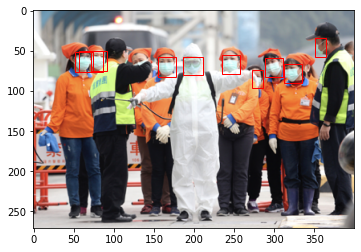

In [ ]:
print("Loaded model guess")
plot_image(imgs[3], pred2[3])